In [1]:
import pandas as pd

In [3]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head(3)

FileNotFoundError: [Errno 2] No such file or directory: 'data/hotels.csv'

In [3]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [4]:
#поиск пропусков

null_data = hotels.isnull().sum()

display(null_data[null_data>0])

lat    2448
lng    2448
dtype: int64

In [5]:
#заполнение пропусокв

hotels_up = hotels.fillna(0)

In [6]:
#повторный поиск пропусков

null_data = hotels_up.isnull().sum()

display(null_data[null_data>0])

Series([], dtype: int64)

In [7]:
# удаление столбцов со строковыми данными

hotels_drop = hotels_up.drop(columns=[
    'hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 
    'negative_review', 'positive_review', 'tags', 'days_since_review'], axis=1)

In [8]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_drop.drop(['reviewer_score'], axis = 1)  
y = hotels_drop['reviewer_score'] 

In [9]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [10]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [12]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.14141148389048333


# Повышение MAPE

Для начала разделим признаки по типу, перечислим их:

In [13]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'lng', 'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given', 'additional_number_of_scoring']

# категориальные признаки
cat_cols = ['average_score', 'lat']

<AxesSubplot:>

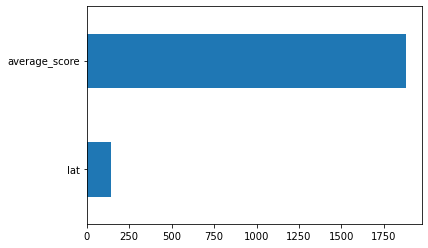

In [14]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

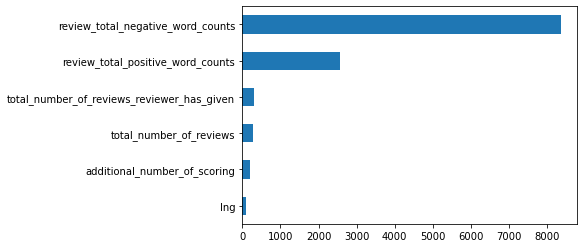

In [15]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

#### Количество отелей в наборе данных

In [16]:
hotels['hotel_name'].describe()

count                                         386803
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            3587
Name: hotel_name, dtype: object

#### Когда был оставлен самый свежий отзыв? Введите ответ в формате yyyy-mm-dd.

In [17]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_date'].max()

Timestamp('2017-08-03 00:00:00')

#### Когда был оставлен самый первый отзыв? Введите ответ в формате yyyy-mm-dd.

In [18]:
hotels['review_date'].min()

Timestamp('2015-08-04 00:00:00')

#### Сколько уникальных тегов представлено в наборе данных

In [19]:
# поиск регулярных выражений

import re

def re_func(num_tags):
    found = re.findall("'[^\'](.+?)[^\']'", num_tags)
    return found


hotels['tags_n'] = hotels['tags'].apply(re_func)
hotels = hotels.explode('tags_n')

hotels['tags_n'].unique()
hotels['tags_n'].value_counts()

Leisure trip                         313593
Submitted from a mobile device       230778
Couple                               189212
Stayed 1 night                       145373
Stayed 2 nights                      100263
                                      ...  
Studio with Spa Access                    1
Comfort Family Room                       1
Junior Suite Free Wifi                    1
Design Suite                              1
Executive Double Room Non Smoking         1
Name: tags_n, Length: 2368, dtype: int64

In [20]:
#подсчет через цикл

tags = list() # множество тегов
for i, row in hotels['tags'].items():
    tmp = row.replace("[' ", "")
    tmp = tmp.replace(" ']", '')
    tmp = tmp.split(" ', ' ")
    for el in tmp:
        if el not in tags:
            tags.append(el)
print(f'Уникальных тегов = {len(tags)}')

Уникальных тегов = 2368


In [ ]:
#подсчет через цикл

tags = list() # множество тегов
for i, row in hotels['hotel_name'].items():
    tmp = row.replace("[' ", "")
    tmp = tmp.replace(" ']", '')
    tmp = tmp.split(" ', ' ")
    for el in tmp:
        if el not in tags:
            tags.append(el)
print(f'Уникальных отелей = {len(tags)}')

Поиск уникальных тегов через цикл в 2 раза дольше.

In [21]:
# удаление столбцов с минимальным влиянием

hotels_drop_2 = hotels_drop.drop(columns=['lat', 'total_number_of_reviews', 'lng', 
'total_number_of_reviews_reviewer_has_given', 'additional_number_of_scoring'
], axis=1)

In [22]:
hotels_drop_2.head()

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,reviewer_score
0,8.4,3,4,10.0
1,8.3,3,2,6.3
2,8.9,6,0,7.5
3,7.5,0,11,10.0
4,8.5,4,20,9.6


In [23]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_drop_2.drop(['reviewer_score'], axis = 1)  
y = hotels_drop_2['reviewer_score'] 

In [24]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [26]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.14231674881353115
